In [1]:
import pandas as pd

df = pd.read_csv('Fraud_Data.csv', parse_dates=['purchase_time', 'signup_time'])

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [3]:
df.isna().values.any()

False

In [4]:
# no missing values
# if there were, I would either:
# 1. drop the column
# 2. drop those records
# 3. replace those missing values

In [5]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
# which columns do I think are not going to be needed
# 1. user_id


In [7]:
df['user_id'].nunique() == df.shape[0]

True

In [8]:
df['device_id'].nunique()

137956

In [9]:
# Device ID are not all unique
# so maybe I can use it for predictions
# for example, create a feature about if they are a repeat device

In [10]:
df['source'].unique()

array(['SEO', 'Ads', 'Direct'], dtype=object)

In [11]:
df['browser'].unique()

array(['Chrome', 'Opera', 'Safari', 'IE', 'FireFox'], dtype=object)

In [12]:
df['sex'].unique()

array(['M', 'F'], dtype=object)

In [13]:
df['ip_address'].nunique()

143512

In [14]:
# For IP address
# maybe consider if we've seen them before
# IP address does not really seem to be like they are IP addresses
# Use IP addres to determine country of origin

In [15]:
df['ip_address'].iloc[3]

3840542443.91396

In [16]:
# repeat device appears more than once
# so I need to determine how many times each device ID appears
# in the data set

df_out = (
    df
    .set_index('device_id')
    .assign(repeat=lambda df: df.index.value_counts() > 1)
    .reset_index()
)

In [17]:
# Well, if you are repeat device, are you more likely to commit fraud?

In [18]:
# for each category of repeat, find the fraction that are fraud
# those that are fraud have a class value of 1

df_out['class'].mean()

0.09364577267192546

In [19]:
df_out.groupby('repeat').agg(mean=('class', 'mean'), count=('class', 'count'))

,mean,count
repeat,,
False,0.030429,131781
True,0.524598,19331


In [20]:
# So what I've learned is that there's a correlation between repeate device and fraud
# I should probably include such feature.
# That feature could be as simple as True/False or continuous (the number of occurences)

In [21]:
df_out.groupby('class')['purchase_value'].mean()

class
0    36.929418
1    36.993004
Name: purchase_value, dtype: float64

In [22]:
df_out.groupby('class')['age'].mean()

class
0    33.122356
1    33.318281
Name: age, dtype: float64

In [23]:
df_out.groupby('source')['class'].mean()

source
Ads       0.092066
Direct    0.105370
SEO       0.089285
Name: class, dtype: float64

In [24]:
df_out.groupby('sex')['class'].mean()

sex
F    0.091007
M    0.095523
Name: class, dtype: float64

In [25]:
df_out.groupby('browser')['class'].mean()

browser
Chrome     0.098792
FireFox    0.095165
IE         0.086775
Opera      0.089227
Safari     0.090201
Name: class, dtype: float64

In [28]:
time_delta = df_out['purchase_time'] - df['signup_time']
time_delta

0        52 days 03:51:22
1         0 days 04:59:04
2         0 days 00:00:01
3         5 days 16:41:25
4        50 days 11:31:01
               ...       
151107   60 days 21:27:13
151108   10 days 18:41:10
151109   77 days 08:00:16
151110   59 days 13:28:39
151111   40 days 19:01:33
Length: 151112, dtype: timedelta64[ns]

In [36]:
time_delta.iloc[0].total_seconds()

4506682.0

In [41]:
time_delta.dt.total_seconds()

0         4506682.0
1           17944.0
2               1.0
3          492085.0
4         4361461.0
            ...    
151107    5261233.0
151108     931270.0
151109    6681616.0
151110    5146119.0
151111    3524493.0
Length: 151112, dtype: float64

In [37]:
52 * 24 * 60 * 60

4492800

In [45]:
df_out = (
    df_out
    .assign(time_diff=lambda df: (df['purchase_time'] - df['signup_time']).dt.total_seconds())
)

In [48]:
df_out.groupby('class')['time_diff'].median()

class
0    5194911.0
1          1.0
Name: time_diff, dtype: float64

In [51]:
df_out = df_out.rename({'class': 'class_'}, axis=1)
df_out.columns

Index(['device_id', 'user_id', 'signup_time', 'purchase_time',
       'purchase_value', 'source', 'browser', 'sex', 'age', 'ip_address',
       'class_', 'repeat', 'time_diff'],
      dtype='object')

<AxesSubplot:>

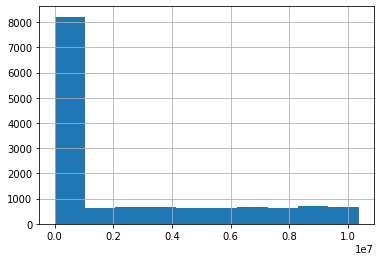

In [52]:
df_out.query('class_ == 1')['time_diff'].hist()

In [53]:
# Note: maybe for time diff we can create a feature that is a boolean
# that says whether someone is a recent signup
# time diff and a threshold (1 day)

In [54]:
df_out['ip_address']

0         7.327584e+08
1         3.503114e+08
2         2.621474e+09
3         3.840542e+09
4         4.155831e+08
              ...     
151107    3.451155e+09
151108    2.439047e+09
151109    2.748471e+09
151110    3.601175e+09
151111    4.103825e+09
Name: ip_address, Length: 151112, dtype: float64

In [59]:
ip_addresses = "\n".join(df['ip_address'].apply(lambda x: str(x)).tolist())

with open('ip_addresses.txt', 'w') as f:
    f.write(ip_addresses)

In [70]:
import requests

def convert_IP_address(ip_address_int):
    """
    Convert integer format IP address to standard 4 octets
    """
    params = {'ip_address': ip_address_int}
    headers = {'User-Agent': 'WQU'}
    response = requests.get("https://www.vultr.com/resources/ipv4-converter/", params=params, headers=headers)
    
    return response

In [71]:
response = convert_IP_address(int(df['ip_address'].iloc[0]))

In [72]:
response.status_code

403

In [73]:
respnse.url

'https://www.vultr.com/resources/ipv4-converter/?ip_address=732758368'

In [75]:
ip_address_int = int(df['ip_address'].iloc[0])

In [85]:
hex(ip_address_int)

'0x2bad0160'

In [84]:
hex(ip_address_int)[-4:]

'0160'

In [87]:
# a = 10
# b = 11
# c = 12
# d = 13

13 + 16 * 10

173

In [ ]:
# 2b -> 43
# ad -> 13 + 16 * 10
# 01 -> 1
# 60 -> 6 * 16 + 0

In [88]:
# convert integer into hexadecimal
# break that hexadecimal into 4 pieces
# convert those 4 pieces into decimal
# glue them all together

In [91]:
examples_in = [
    732758368,
    350311387,
    2621473820,
    3840542443,
    415583117,
]

In [92]:
example_out = [
    '43.173.1.96'
    '20.225.83.219'
    '156.64.132.28'
    '228.234.6.235'
    '24.197.75.141'
]

In [93]:
test_cases = zip(examples_in, example_out)

In [121]:
def convert_to_standard(ip_address_int):
    """
    Convert integer format IP addres to the standard 4 octets
    """
    octets = []
    
    ip_address_hex = hex(ip_address_int)
    for index in range(2, 10, 2):
        part = ip_address_hex[index:index + 2]
        octet = int(part, 16)
        octets.append(str(octet))
        
    return ".".join(octets)

In [122]:
list(range(2, 16, 2))

[2, 4, 6, 8, 10, 12, 14]

In [123]:
int('0x' + hex(ip_address_int)[2:4], 16)

43

In [124]:
hex(732758368)

'0x2bad0160'

In [125]:
convert_to_standard(732758368)

'43.173.1.96'

In [129]:
for trial, ans in test_cases:
    #print(trial, ans)
    assert ans == convert_to_standard(trial)